In general, looking at the generalization curves, that is the training loss and the validation loss curves, if the training loss keeps decreasing and converges but the validation curve decreases upto some level and then increases, this shows that the model is overfitting.

We could stop or avoid overfitting the data by penalizing the complex models, this is know as regularization.

Insted of aiming to minimize loss that is emperical risk mnimization, we have to aim at minimize the loss+model complexity that it structural risk minimization.

Now the training optimization term consists of two major terms, loss term - which tells how good the algorithm is and regularization term - it tells how complex the model is.

one of the ways to quantify the complexity is using the $L_2$ regularization. which is defined as the sum of sqares of all the weight terms.

To tune the impact of regularization term, it is multiplied with a scalar factor known as lambda $\lambda$

Effect of $L_2$ regularization:
* encourages weight values towards 0
* encouragess mean value of wights towards 0 with a normal distribution.



Logistic regression, generates the probability between 0 and 1.

here we use the logistic function or sigmoid function to predict the probability.
 $$y = \frac {1}{1+e^{-z}}$$

Here the loss function is defines as cross entropy loss function.

$$lossL = \sum -ylogy' - (1-y)log(1-y')$$

In orfer to map the logistic regression value to a binary value we define a classification threshold value, that is known as decision threshold.

we summarize the model predictions using the confusion matrix. which consists of all the possible outcomes.

$$ConfusionMatrix = \begin{pmatrix}TruePositive & FalsePositive \\ FalseNegative & TrueNegative \end{pmatrix}$$

* True positive is an outcome where model correctly predicts the positive class.
* True negative is an outcome where model correctly predict negative class.
* False positive is an outcome where model incorrectly predicts the positive class.
* False negative is an outcome where model incorrectly predict negative class.

In case of classification problems using logistic regression, we set a threshold limit and check the accuracy of the output to check the performance of model.

$$Accuracy = \frac {NumberOfCorrectPredictions}{TotalNumber OfPredictions}$$

In case of binary classification problesms.

$$Accuracy = \frac {TP + TN}{TP + TN + FP + FN}$$

Along with accuracy we use precision and recall scores.

precision = true positive / all positive predictions.

$$Precision = \frac {TP}{TP + FP}$$

recall = true positives / all actual positives.

$$Recall = \frac {TP}{TP + FN}$$

An ROC curve (Receiver Operating CHarectaristics curve), is a graph showing the performance of the classification model at all threshold values. This curve plots two values.
* True positive rate.
$$TPR = \frac {TP}{TP + FN}$$
* False positive rate.
$$FPR = \frac {FP}{FP + TN}$$

Logistic regression predictions should be unbiased. that is

average of predictions = average of observations.

prediction bias is the quantity that tells how far apart the two averages are.

prediction bias = average of predictions - average of labels in data.



In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv', sep=',')
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2198,-117.4,33.9,21.0,2468.0,380.0,1164.0,385.0,4.1,136800.0
12571,-121.7,39.2,26.0,2121.0,375.0,1125.0,366.0,3.4,94600.0
16951,-124.2,40.8,50.0,340.0,74.0,235.0,83.0,1.8,67500.0
8258,-118.5,34.3,9.0,1739.0,358.0,820.0,323.0,4.1,182500.0
14654,-122.2,39.5,28.0,1471.0,259.0,673.0,246.0,3.2,81600.0


In [0]:
def preprocess_features(cfd):

  selected_features = cfd[["latitude", "longitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]]

  processed_features = selected_features.copy()
  processed_features['rooms_per_person'] = cfd['total_rooms'] / cfd['population']

  return processed_features

In [0]:
def preprocess_targets(cfd):

  target = pd.DataFrame()
  target['median_house_value_is_high'] = (cfd['median_house_value'] > 265000).astype(float)

  return target

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.head()

,median_house_value_is_high
16788,0.0
3393,0.0
7437,1.0
8060,1.0
6968,0.0


In [0]:
def construct_feature_columns(input_featuers):

  return set([tf.feature_column.numeric_column(my_features) for my_features in input_featuers])

In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle=True, epochs=None):

  features = {key:np.array(value) for key,value in dict(features).items()}

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  features, targets = ds.make_one_shot_iterator().get_next()

  return features, targets

In [0]:
def train_linear_regressor_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):

  periods = 10
  steps_per_period = steps / periods

  my_optimizor = tf.train.GradientDescentOptimizer(learning_rate)
  my_optimizor = tf.contrib.estimator.clip_gradients_by_norm(my_optimizor, 5.0)

  linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizor)

  training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, shuffle=False, epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, shuffle=False, epochs=1)

  print('training model')
  print('RMSE on training data')
  training_RMSE = []
  validation_RMSE = []
  for period in range(periods):

    linear_regressor.train(training_input_fn, steps=steps_per_period)

    prediction_training = linear_regressor.predict(predict_training_input_fn)
    prediction_training = np.array([items['predictions'][0] for items in prediction_training])

    prediction_validation = linear_regressor.predict(predict_validation_input_fn)
    prediction_validation = np.array([items['predictions'][0] for items in prediction_validation])

    rmse_training = math.sqrt(metrics.mean_squared_error(prediction_training, training_targets))
    print("period %02d training examples : %0.2f" % (period, rmse_training))

    rmse_validation = math.sqrt(metrics.mean_squared_error(prediction_validation, validation_targets))
    print("period %02d validation examples : %0.2f" % (period, rmse_validation))

    training_RMSE.append(rmse_training)
    validation_RMSE.append(rmse_validation)

  print('training complete')
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_RMSE, label="training")
  plt.plot(validation_RMSE, label="validation")
  plt.legend()

  return linear_regressor

training model
RMSE on training data
period 00 training examples : 0.45
period 00 validation examples : 0.46
period 01 training examples : 0.44
period 01 validation examples : 0.45
period 02 training examples : 0.44
period 02 validation examples : 0.45
period 03 training examples : 0.44
period 03 validation examples : 0.45
period 04 training examples : 0.44
period 04 validation examples : 0.45
period 05 training examples : 0.44
period 05 validation examples : 0.45
period 06 training examples : 0.44
period 06 validation examples : 0.45
period 07 training examples : 0.44
period 07 validation examples : 0.45
period 08 training examples : 0.44
period 08 validation examples : 0.45
period 09 training examples : 0.44
period 09 validation examples : 0.45
training complete


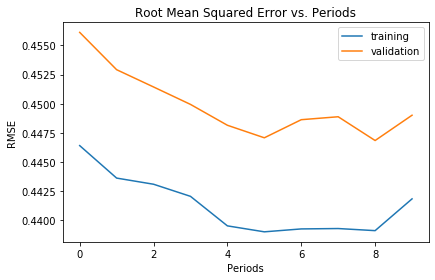

In [0]:
linear_regressor = train_linear_regressor_model(0.000001,200,20,training_examples,training_targets,validation_examples,validation_targets)

In [0]:
# training with log loss
def train_linear_classifier_model_with_log_loss(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):

  periods = 10
  steps_per_period = steps / periods

  my_optimizor = tf.train.GradientDescentOptimizer(learning_rate)
  my_optimizor = tf.contrib.estimator.clip_gradients_by_norm(my_optimizor, 5.0)

  linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizor)

  training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, shuffle=False, epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, shuffle=False, epochs=1)

  print('training model')
  print('RMSE on training data')
  training_logloss = []
  validation_logloss = []
  for period in range(periods):

    linear_classifier.train(training_input_fn, steps=steps_per_period)

    prob_training = linear_classifier.predict(predict_training_input_fn)
    prob_training = np.array([items['probabilities'] for items in prob_training])

    prob_validation = linear_classifier.predict(predict_validation_input_fn)
    prob_validation = np.array([items['probabilities'] for items in prob_validation])

    logloss_training = metrics.log_loss(training_targets, prob_training)
    print("period %02d training examples : %0.2f" % (period, logloss_training))

    logloss_validation = metrics.log_loss(validation_targets, prob_validation)
    print("period %02d validation examples : %0.2f" % (period, logloss_validation))

    training_logloss.append(logloss_training)
    validation_logloss.append(logloss_validation)

  print('training complete')
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("Log Loss vs. Periods")
  plt.tight_layout()
  plt.plot(training_logloss, label="training")
  plt.plot(validation_logloss, label="validation")
  plt.legend()

  return linear_regressor

training model
RMSE on training data
period 00 training examples : 0.60
period 00 validation examples : 0.60
period 01 training examples : 0.58
period 01 validation examples : 0.59
period 02 training examples : 0.57
period 02 validation examples : 0.57
period 03 training examples : 0.56
period 03 validation examples : 0.57
period 04 training examples : 0.55
period 04 validation examples : 0.56
period 05 training examples : 0.54
period 05 validation examples : 0.55
period 06 training examples : 0.53
period 06 validation examples : 0.54
period 07 training examples : 0.53
period 07 validation examples : 0.54
period 08 training examples : 0.53
period 08 validation examples : 0.54
period 09 training examples : 0.52
period 09 validation examples : 0.54
training complete


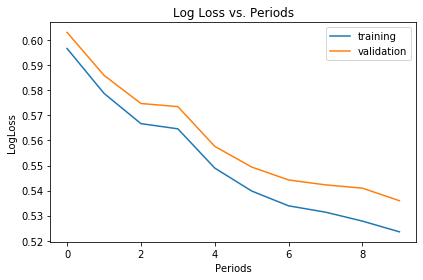

In [0]:
linear_classifier = train_linear_classifier_model_with_log_loss(0.000005,500,20,training_examples,training_targets,validation_examples,validation_targets)

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, shuffle=False, epochs=1)

prob_validation = linear_classifier.predict(predict_validation_input_fn)
prob_validation = np.array([item['probabilities'][1] for item in prob_validation])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets, prob_validation)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.legend(loc=2)
plt.show()

KeyError: ignored

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  epochs=1, 
                                                  shuffle=False)

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
print(validation_probabilities)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

<generator object Estimator.predict at 0x7f5f9f1a8678>


KeyError: ignored

In [0]:
linear_classifier = train_linear_classifier_model_with_log_loss(0.000005,500,20,training_examples,training_targets,validation_examples,validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])